---
## News Scraping by parallelization
    In this scrip I built a function to scrape news using the library "newspaper"  https://github.com/codelucas/newspaper/ and I apply it over the urls downloaded in Media-Cloud. 
    
---

In [3]:
pip install newspaper3k

  Using cached newspaper3k-0.2.8-py3-none-any.whl (211 kB)
  Using cached cssselect-1.2.0-py2.py3-none-any.whl (18 kB)
  Using cached lxml-4.9.4-cp311-cp311-macosx_10_9_x86_64.whl
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached feedparser-6.0.11-py3-none-any.whl.metadata (2.4 kB)
  Using cached tldextract-5.1.1-py3-none-any.whl.metadata (11 kB)
  Using cached feedfinder2-0.0.4-py3-none-any.whl
  Using cached jieba3k-0.35.1-py3-none-any.whl
  Using cached tinysegmenter-0.3-py3-none-any.whl
  Using cached sgmllib3k-1.0.0-py3-none-any.whl
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached regex-2023.12.25-cp311-cp311-macosx_10_9_x86_64.whl.metadata (40 kB)
  Using cached requests_file-1.5.1-py2.py3-none-any.whl (3.7 kB)
  Using cached filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
Using cached feedparser-6.0.11-py3-none-any.whl (81 kB)
Using cached tldextract-5.1.1-py3-none-any.

In [4]:
## Import libraries to work with
import time
import pandas as pd #data manipulation
from newspaper import Article
import requests #handling HTTP requests
from concurrent.futures import ThreadPoolExecutor ## parallelization

In [26]:
def fetch_articles_new(ids, urls):
    """
    Fetches articles from URLs, extracts data, and handles errors.
    Returns a DataFrame with extracted data and a list of errors.
    """
    # Initialize a dictionary to store article data and errors
    article_data = {
        'ID': [],
        'URL': [],
        'Body': [],
        'MetaData': [],
        'Authors': [],
        'Date': [],
        'Title': [],
        'Tags': [],
        'MetaKeywords': [],
        'Summary': [],
        'Error': [],  # New column for error messages
    }

    errors = []  # List to store error messages
    
    start_time = time.time()  # Record the start time

     # Loop through the IDs and URLs simultaneously
    for id_, url in zip(ids, urls):
        try:
            article = Article(url)
            article.download()
            article.parse()
            
            # Append the parsed article to the dictionary
            article_data['ID'].append(id_)
            article_data['URL'].append(url)
            article_data['Body'].append(article.text)
            article_data['MetaData'].append(article.meta_description)
            article_data['Authors'].append(article.authors)
            article_data['Date'].append(article.publish_date)
            article_data['Title'].append(article.title)
            article_data['Tags'].append(article.tags)
            article_data['MetaKeywords'].append(article.meta_keywords)
            
            article.nlp()
            article_data['Summary'].append(article.summary)
            
            # No error, so add an empty string to the 'Error' column
            article_data['Error'].append('')
            
            # Introduce a sleep to avoid being blocked
            time.sleep(3)  # Sleep for 3 seconds
            
        
        except requests.exceptions.RequestException as e:
            # Handle URL-related exceptions
            article_data['Error'].append(str(e))
            errors.append(str(e))  # Append error to the list
            
            # Append 'ID' and 'URL'
            article_data['ID'].append(id_)
            article_data['URL'].append(url)
            
            # Append placeholders for other columns
            for column in ['Body', 'MetaData', 'Authors', 'Date', 'Title', 'Tags', 'MetaKeywords', 'Summary']:
                article_data[column].append('NA')
                
        except Exception as e:
            # Handle other exceptions (e.g., parsing errors)
            article_data['Error'].append(str(e))
            errors.append(str(e))  # Append error to the list
            
            # Append 'ID' and 'URL'
            article_data['ID'].append(id_)
            article_data['URL'].append(url)
            
            # Append placeholders for other columns
            for column in ['Body', 'MetaData', 'Authors', 'Date', 'Title', 'Tags', 'MetaKeywords', 'Summary']:
                article_data[column].append('NA')
    
    end_time = time.time()  # Record the end time
    
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    
    print(f"Time taken to fetch and parse articles: {elapsed_time:.2f} seconds")
    
    return pd.DataFrame(article_data), errors

In [144]:
pkl_url = pd.read_pickle("/Users/trinidadbosch/Desktop/SEDS/Tesis/Data/MA-Thesis/Media Cloud/Data/media_urls.pkl")

In [145]:
pkl_url.columns

Index(['ap_syndicated', 'collect_date', 'feeds', 'guid', 'language',
       'media_id', 'media_name', 'media_url', 'metadata',
       'processed_stories_id', 'publish_date', 'stories_id', 'story_tags',
       'title', 'url', 'word_count'],
      dtype='object')

In [146]:
pkl_url.publish_date

0         2021-02-01 03:11:18
1         2021-02-01 13:28:31
2         2021-02-01 13:17:36
3         2021-02-01 02:05:19
4         2021-02-01 14:07:26
                 ...         
192989    2023-11-01 17:21:46
192990    2023-10-30 19:46:44
192991    2023-11-01 18:00:00
192992    2023-10-31 18:00:00
192993    2023-11-01 09:00:00
Name: publish_date, Length: 192994, dtype: object

---
# Apply scraping function in paralell
    This process took ~20hrs
---

In [31]:
# Specify the number of chunks
num_chunks = 100

# Calculate the size of each chunk
chunk_size = len(pkl_url) // num_chunks

# Split the DataFrame into chunks
df_chunks = [pkl_url.iloc[i:i + chunk_size] for i in range(0, len(pkl_url), chunk_size)]

# Function to apply in parallel
def process_chunk(chunk):
    chunk_ids = chunk['stories_id'].tolist()
    chunk_urls = chunk['url'].tolist()
    
    return fetch_articles_new(chunk_ids, chunk_urls)

# Apply the function in parallel using ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_chunk, df_chunks))

Time taken to fetch and parse articles: 3784.77 seconds
Time taken to fetch and parse articles: 4202.48 seconds
Time taken to fetch and parse articles: 5815.62 seconds
Time taken to fetch and parse articles: 5924.41 seconds
Time taken to fetch and parse articles: 6227.64 seconds
Time taken to fetch and parse articles: 6367.67 seconds
Time taken to fetch and parse articles: 6432.34 seconds
Time taken to fetch and parse articles: 6619.20 seconds
Time taken to fetch and parse articles: 5454.46 seconds
Time taken to fetch and parse articles: 3411.00 seconds
Time taken to fetch and parse articles: 3689.31 seconds
Time taken to fetch and parse articles: 7391.17 seconds
Time taken to fetch and parse articles: 6684.15 seconds
Time taken to fetch and parse articles: 6778.27 seconds
Time taken to fetch and parse articles: 6661.36 seconds
Time taken to fetch and parse articles: 6498.51 seconds
Time taken to fetch and parse articles: 4893.06 seconds
Time taken to fetch and parse articles: 4665.54 

Building prefix dict from /opt/anaconda3/lib/python3.8/site-packages/jieba/dict.txt ...
Dumping model to file cache /var/folders/vk/yr_rw4912x38st74np992k1r0000gn/T/jieba.cache
Loading model cost 3.11118221282959 seconds.
Prefix dict has been built succesfully.


Time taken to fetch and parse articles: 4385.26 seconds
Time taken to fetch and parse articles: 3492.28 seconds
Time taken to fetch and parse articles: 4274.16 seconds
Time taken to fetch and parse articles: 5542.20 seconds
Time taken to fetch and parse articles: 3882.53 seconds
Time taken to fetch and parse articles: 6708.33 seconds
Time taken to fetch and parse articles: 6249.68 seconds
Time taken to fetch and parse articles: 6659.23 seconds
Time taken to fetch and parse articles: 6318.34 seconds
Time taken to fetch and parse articles: 6664.81 seconds
Time taken to fetch and parse articles: 3367.04 seconds
Time taken to fetch and parse articles: 3321.14 seconds
Time taken to fetch and parse articles: 5339.08 seconds
Time taken to fetch and parse articles: 6585.64 seconds
Time taken to fetch and parse articles: 3748.51 seconds
Time taken to fetch and parse articles: 3830.97 seconds
Time taken to fetch and parse articles: 3487.06 seconds
Time taken to fetch and parse articles: 4997.63 

In [32]:
# Extract DataFrames from the tuple results
result_dataframes = [result[0] for result in results]

# Concatenate the DataFrames into a single DataFrame
final_result = pd.concat(result_dataframes, ignore_index=True)

# Display the final DataFrame
(final_result)

,ID,URL,Body,MetaData,Authors,Date,Title,Tags,MetaKeywords,Summary,Error
0,1838925040,https://news.mongabay.com/2021/02/eye-in-the-s...,An interdisciplinary team of zoologists and co...,Environmental science and conservation news,[Terna Gyuse],2021-02-01 08:11:18+00:00,Eye in the Sky: Tech makes satellite imagery i...,"{Wildlife, Animals, Jim Tan, Endangered Specie...",[],Satellite surveying still offers many advantag...,
1,1839017422,https://www.cnbc.com/2021/02/01/amazon-alphabe...,"Ali Ghodsi, co-founder and CEO of Databricks I...","Amazon is getting involved in the start-up, Da...",[Jordan Novet],2021-02-01 00:00:00,"Amazon, Alphabet and Salesforce are all invest...",{},"[Start-up, Venture capital, Microsoft Corp, Sa...","Ali Ghodsi, co-founder and CEO of Databricks I...",
2,1839009079,http://feeds.benzinga.com/~r/benzinga/~3/JWduJ...,One of the hottest names in the investing worl...,One of the hottest names in the investing worl...,[Chris Katje],None,15 Big Ideas In 'Disruptive Innovation' Accord...,"{Government, Digital Wallets, Healthcare, Poli...",[],One of the hottest names in the investing worl...,
3,1838767296,https://eurweb.com/2021/01/31/black-creators-a...,*It’s day four at the 2021 Sundance Film Festi...,,[Olivia T.],2021-01-31 00:00:00,Black Creators At Sundance 2021,"{white wedding, sundance, Sophia Nahli Allison...",[],*It’s day four at the 2021 Sundance Film Festi...,
4,1839090241,http://feeds.benzinga.com/~r/benzinga/~3/y-hmu...,Loading... Loading...\n\nBill.com BILL shares ...,Bill.com (NYSE: BILL) shares are trading highe...,[Tanzeel Akhtar],None,Why Bill.com's Stock Is Trading Higher Today -...,"{Government, Healthcare, Politics, Regulations...",[],Loading... Loading...Bill.com BILL shares are ...,
...,...,...,...,...,...,...,...,...,...,...,...
192989,2816117787,https://arstechnica.com/?p=1980413,"On Wednesday, the UK hosted an AI Safety Summi...","""Bletchley Declaration"" sums up first day of U...",[Benj Edwards],2023-11-01 21:21:46+00:00,“Catastrophic” AI harms among warnings in decl...,{},[],"The event included the signing of ""The Bletchl...",
192990,2816156060,https://www.cnbc.com/2023/10/31/stock-markets-...,Traders work on the floor of the New York Stoc...,After a rough week amid accelerating inflation...,[Yeo Boon Ping],2023-10-31 00:00:00,CNBC Daily Open: Markets’ bounce may be short-...,{},"[Technology, Autos, Morgan Stanley, Meta Platf...","This report is from today's CNBC Daily Open, o...",
192991,2818282751,https://doakio.com/blog/missteps-in-blockchain...,Introduction\n\nIn the world of blockchain tec...,,"[Rachele Augusto, Var Molongui_Authorship_Fron...",2023-11-01 22:00:00+00:00,Missteps in Blockchain Documentation: A Review,{Uncategorized},[],The Importance of Accurate Blockchain Document...,
192992,2818282763,https://doakio.com/blog/why-jargon-isnt-always...,Introduction\n\nWelcome to the world of techni...,,"[Rachele Augusto, Var Molongui_Authorship_Fron...",2023-10-31 22:00:00+00:00,Why Jargon Isn’t Always the Enemy: Technical v...,{Uncategorized},[],The Pitfalls of Over-Simplifying Technical Ter...,


In [33]:
# Save to CSV
final_result.to_csv('/Users/trinidadbosch/Desktop/SEDS/Tesis/Data/MA-Thesis/Media Cloud/Data/scraped_news.csv', index=False)

# Save to pickle
final_result.to_pickle('/Users/trinidadbosch/Desktop/SEDS/Tesis/Data/MA-Thesis/Media Cloud/Data/scraped_news.pkl')

---
### Descriptive analysis of the scraped
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
scraped = pd.read_pickle('/Users/trinidadbosch/Desktop/SEDS/MA-Thesis/thesis-env/Media Cloud/Data/scraped_news.pkl')

In [3]:
# Identify non-empty cells in the specified column
error_rows = scraped[scraped['Body'] == 'NA']

In [20]:
error_rows

,ID,URL,Body,MetaData,Authors,Date,Title,Tags,MetaKeywords,Summary,Error
8,1839132269,https://www.ibtimes.com/sex-zoom-hookups-ai-fl...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
9,1839039085,https://www.ibtimes.com/ford-put-google-cloud-...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
13,1838735606,https://www.forbes.com/sites/eliamdur/2021/02/...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
14,1839104848,http://feeds.baltimoresun.com/~r/baltimoresun/...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 404 Client Er...
20,1839193535,https://www.forbes.com/sites/stevebanker/2021/...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
...,...,...,...,...,...,...,...,...,...,...,...
192958,2814875288,https://www.wsj.com/articles/ai-wont-stop-peop...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
192959,2814884038,https://www.wsj.com/articles/ai-wont-stop-peop...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
192965,2814904118,https://www.forbes.com/sites/scottkramer/2023/...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
192966,2814904142,https://www.seattletimes.com/opinion/ais-chall...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with HTTPSConnecti...


In [4]:
error_rows = error_rows.drop_duplicates(subset='URL', keep='first')

In [9]:
error_rows

,ID,URL,Body,MetaData,Authors,Date,Title,Tags,MetaKeywords,Summary,Error
8,1839132269,https://www.ibtimes.com/sex-zoom-hookups-ai-fl...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
9,1839039085,https://www.ibtimes.com/ford-put-google-cloud-...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
13,1838735606,https://www.forbes.com/sites/eliamdur/2021/02/...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
14,1839104848,http://feeds.baltimoresun.com/~r/baltimoresun/...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 404 Client Er...
20,1839193535,https://www.forbes.com/sites/stevebanker/2021/...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
...,...,...,...,...,...,...,...,...,...,...,...
192465,2812850960,https://biztoc.com/x/85b4961e1a853ad4?ref=ff,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 429 Client Er...
192466,2812851411,https://biztoc.com/x/1d4d8ffa24589087?ref=ff,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 429 Client Er...
192467,2812852477,https://biztoc.com/x/c87e0fb940742caf?ref=ff,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 429 Client Er...
192556,2813304841,https://biztoc.com/x/ec4fcc8ec963e82f?ref=ff,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 429 Client Er...


In [5]:
urls = pd.read_pickle('/Users/trinidadbosch/Desktop/SEDS/MA-Thesis/thesis-env/Media Cloud/Data/media_urls.pkl')

In [6]:
## join non scraped with urls to extract the information
result_df = urls.merge(error_rows, left_on='stories_id', right_on='ID', how='inner')
result_df

,ap_syndicated,collect_date,feeds,guid,language,media_id,media_name,media_url,metadata,processed_stories_id,...,URL,Body,MetaData,Authors,Date,Title,Tags,MetaKeywords,Summary,Error
0,False,2021-02-01 14:55:28.842599,NaN,https://www.ibtimes.com/sex-zoom-hookups-ai-fl...,en,41550,IBTimes,http://www.ibtimes.com/,"{'date_guess_method': None, 'extractor_version...",2248338036,...,https://www.ibtimes.com/sex-zoom-hookups-ai-fl...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
1,False,2021-02-01 14:55:28.842599,NaN,https://www.ibtimes.com/sex-zoom-hookups-ai-fl...,en,41550,IBTimes,http://www.ibtimes.com/,"{'date_guess_method': None, 'extractor_version...",2248338036,...,https://www.ibtimes.com/sex-zoom-hookups-ai-fl...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
2,False,2021-02-01 14:55:28.842599,NaN,https://www.ibtimes.com/sex-zoom-hookups-ai-fl...,en,41550,IBTimes,http://www.ibtimes.com/,"{'date_guess_method': None, 'extractor_version...",2248338036,...,https://www.ibtimes.com/sex-zoom-hookups-ai-fl...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
3,False,2021-02-01 13:59:59.844832,NaN,https://www.ibtimes.com/ford-put-google-cloud-...,en,41550,IBTimes,http://www.ibtimes.com/,"{'date_guess_method': None, 'extractor_version...",2248350200,...,https://www.ibtimes.com/ford-put-google-cloud-...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
4,False,2021-02-01 13:59:59.844832,NaN,https://www.ibtimes.com/ford-put-google-cloud-...,en,41550,IBTimes,http://www.ibtimes.com/,"{'date_guess_method': None, 'extractor_version...",2248350200,...,https://www.ibtimes.com/ford-put-google-cloud-...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76850,False,2020-01-06 16:36:08.262740,NaN,https://parade.com/951214/alexandra-hurtado/di...,en,33514,Parade,http://www.parade.com#spider,"{'date_guess_method': None, 'extractor_version...",1884810236,...,https://parade.com/951214/alexandra-hurtado/di...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
76851,False,2020-03-18 02:39:28.974520,NaN,https://www.investors.com/research/ibd-stock-o...,en,27011,Investors,http://www.investors.com,"{'date_guess_method': None, 'extractor_version...",1958895568,...,https://www.investors.com/research/ibd-stock-o...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
76852,False,2020-03-18 23:27:01.450420,NaN,https://www.investors.com/news/technology/digi...,en,27011,Investors,http://www.investors.com,{'date_guess_method': {'stories_id': 155249903...,1959727867,...,https://www.investors.com/news/technology/digi...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...
76853,False,2020-08-07 06:57:03.814853,NaN,https://blogs.wsj.com/experts/2019/11/27/why-o...,en,1150,Wall Street Journal,https://www.wsj.com/,{'date_guess_method': {'stories_id': 167690731...,2090235874,...,https://blogs.wsj.com/experts/2019/11/27/why-o...,NA,NA,NA,NA,NA,NA,NA,NA,Article `download()` failed with 403 Client Er...


In [8]:
urls = urls.drop_duplicates(subset='url', keep='first')

In [7]:
result_df = result_df.drop_duplicates(subset='URL', keep='first')

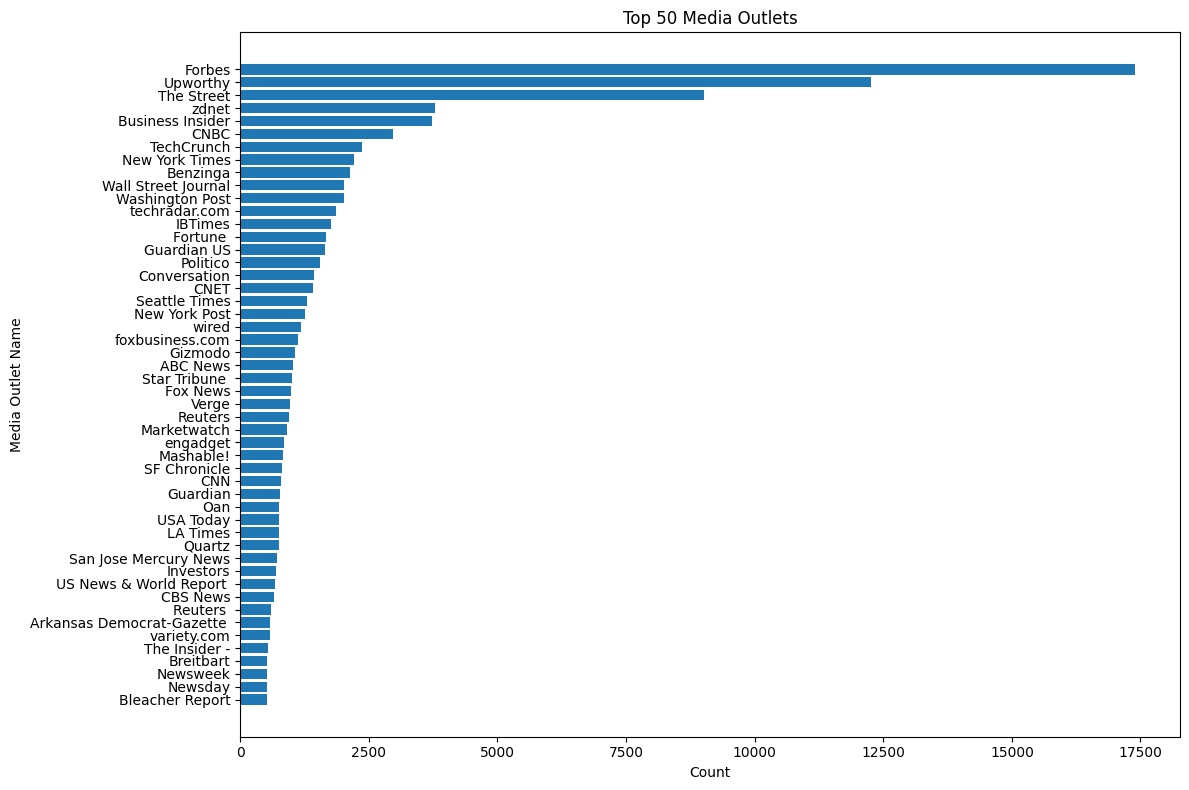

In [9]:
# Get the counts of unique values in the 'media_name' column
value_counts = urls['media_name'].value_counts()

# Select the top 50 values and sort in descending order
top_50_values = value_counts.head(50).sort_values(ascending=True)

# Set a larger figure size
plt.figure(figsize=(12, 8))

# Plot a bar chart with rotated x-axis labels
plt.barh(top_50_values.index, top_50_values.values)

plt.xlabel('Count')
plt.ylabel('Media Outlet Name')

# Add title
plt.title('Top 50 Media Outlets')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('top-50-media-outlet.png')
plt.show()

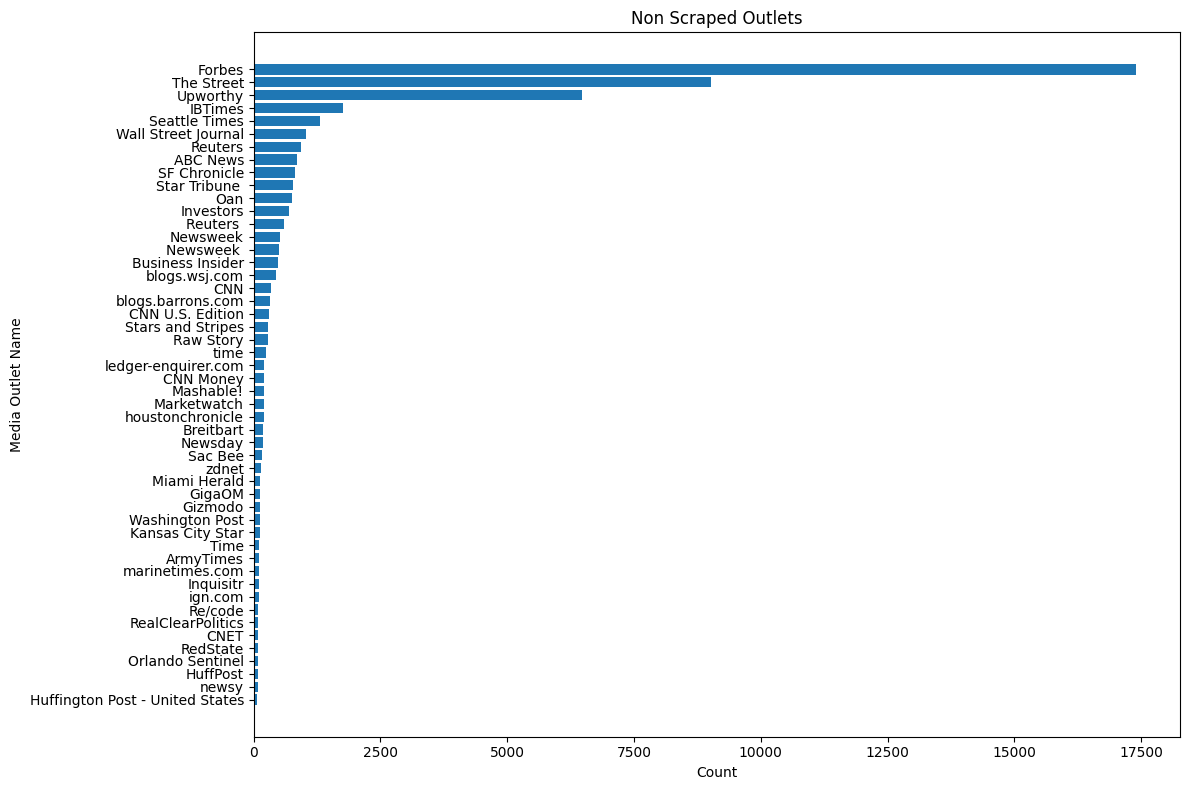

In [10]:
# Get the counts of unique values in the 'media_name' column
value_counts = result_df['media_name'].value_counts()

# Select the top 50 values and sort in descending order
top_50_values = value_counts.head(50).sort_values(ascending=True)

# Set a larger figure size
plt.figure(figsize=(12, 8))

# Plot a bar chart with rotated x-axis labels
plt.barh(top_50_values.index, top_50_values.values)

plt.xlabel('Count')
plt.ylabel('Media Outlet Name')

# Add title
plt.title('Non Scraped Outlets')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('non-scraped-media.png')
plt.show()


In [11]:
top_50_values

media_name
Huffington Post - United States       75
newsy                                 77
HuffPost                              77
Orlando Sentinel                      78
RedState                              80
CNET                                  84
RealClearPolitics                     86
Re/code                               94
ign.com                               99
Inquisitr                            100
marinetimes.com                      104
ArmyTimes                            107
Time                                 115
Kansas City Star                     117
Washington Post                      124
Gizmodo                              125
GigaOM                               132
Miami Herald                         135
zdnet                                140
Sac Bee                              166
Newsday                              182
Breitbart                            193
houstonchronicle                     195
Marketwatch                          205
Masha

---
## Scraping with BS
    Effort to get those urls that threw error with the previous function
---

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import concurrent

In [9]:
urls = ['https://www.seattletimes.com/business/stellantis-foxconn-team-up-to-make-cars-more-connected/?utm_source=RSS&utm_medium=Referral&utm_campaign=RSS_all',
 'https://www.thestreet.com/press-releases/u-s-air-force-awards-booz-allen-950m-idiq-contract-15412250',
 'https://abcnews.go.com/International/wireStory/british-political-candidate-artificial-intelligence-draw-election-manifesto-101487427']
ids = ['1934724599', '1697865428','2717045621']

In [11]:
ids

['1934724599', '1697865428', '2717045621']

In [36]:
response = requests.get( 'https://www.forbes.com/video/6338244857112/')

In [37]:
soup = BeautifulSoup(response.text, 'html.parser')
title = (soup.find('title')).get_text()
body = soup.find_all('p')

In [38]:
title

"America's Richest Tech Billionaires 2023"

In [30]:
def forbes_scrape(urls, ids_):
    article_data = {
        'ID': [],
        'URL': [],
        'Body': [],
        'Title': [],
        'Error': [],
    }

    errors = []

    start_time = time.time()

    for url, id_ in zip(urls, ids_):  # Use zip to iterate over both lists simultaneously
        try:
            # Adding a delay between requests to avoid being blocked
            time.sleep(5)
            
            response = requests.get(url)
            response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)
            
            soup = BeautifulSoup(response.text, 'html.parser')
           # title = (soup.find('title')).get_text()
            title_element = soup.find('title')
            title = title_element.get_text() if title_element else None

            body = soup.find_all('p')

            article_data['Title'].append(title)

            body_text = ""
            for text in body:
                body_text += text.get_text() + "\n"

            article_data['Body'].append(body_text)
            article_data['ID'].append(id_)
            article_data['URL'].append(url)
            article_data['Error'].append(None)  # No error for this entry
            
        except requests.exceptions.RequestException as e:
            errors.append(f"Error processing URL {url}: {str(e)}")
            article_data['Title'].append(None)
            article_data['Body'].append(None)
            article_data['ID'].append(id_)
            article_data['URL'].append(url)
            article_data['Error'].append(str(e))

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Time taken to fetch and parse articles: {elapsed_time:.2f} seconds")

    if errors:
        print("Errors:")
        for error in errors:
            print(error)

    return pd.DataFrame(article_data)

In [2]:
news = pd.read_csv('/Users/trinidad/Desktop/Thesis/MA-Thesis/Media Cloud/Data/scraped_news.csv')
urls_raw = pd.read_pickle('/Users/trinidad/Desktop/Thesis/MA-Thesis/Media Cloud/Data/media_urls.pkl')
forbes = pd.read_csv('forbes_scrape.csv')

In [20]:
nan_body_rows = news[news['Body'].isna()]
rows_work = nan_body_rows.drop_duplicates(subset='URL')

In [17]:
forbes_urls = urls_raw[urls_raw['media_name'] == 'Forbes']

In [31]:
forbes_urls

['https://www.forbes.com/sites/renaegregoire/2023/10/01/ai-showdown-part-3-chatgpt-claude-bing-and-bard-on-social--email/',
 'https://www.forbes.com/sites/mollybohannon/2023/10/01/paw-patrol-sequel-leads-weekend-box-office-and-beats-prequel-as-saw-x-takes-second-spot/',
 'https://www.forbes.com/sites/billeehoward/2023/10/01/top-4-insights-all-c-suite-leaders--market-researchers-need-to-be-aware-of-in-2024/',
 'https://www.forbes.com/sites/robtoews/2023/10/01/10-blockbuster-ai-ma-deals-on-the-horizon/',
 'https://www.forbes.com/sites/emmawoollacott/2023/10/02/freedom-on-the-net-report-highlights-dangers-of-ai/',
 'https://www.forbes.com/sites/forbestechcouncil/2023/10/02/is-your-organization-undergoing-an-identity-crisis/',
 'https://www.forbes.com/sites/forbesagencycouncil/2023/10/02/communications-30-nuance-is-the-key-ingredient/',
 'https://www.forbes.com/sites/forbestechcouncil/2023/10/02/ai-innovation-or-speculation-a-guide-to-understanding-the-difference/',
 'https://www.forbes.co

In [19]:
forbes_id = forbes_urls['stories_id'].tolist()
forbes_urls = forbes_urls['url'].tolist()

In [40]:
## Scraping Forbes articles
result_df = forbes_scrape(forbes_urls,forbes_id)

Time taken to fetch and parse articles: 3581.47 seconds


In [42]:
## save articles
result_df.to_csv('forbes_scrape.csv', index=False)

In [9]:
missing_values.value() - missing_values.sum()

116881

In [3]:
# Identify missing values in the specified column
missing_values = news['Body'].isnull()

# Drop rows with missing values in the specified column
news_clean = news[~missing_values]

In [15]:
missing_values.value_counts() ##76113 NaN in Body
duplicated_values = news_clean['ID'].duplicated()
duplicated_values.value_counts()

ID
False    79944
True     36937
Name: count, dtype: int64

In [17]:
duplicates_count = news_clean['ID'].duplicated().sum()

In [16]:
# Drop rows with duplicated values in the specified column
news_clean.drop_duplicates(subset='ID', keep='first', inplace=True)

/var/folders/40/_xs977_s23jff20ybrgxbmmw0000gn/T/ipykernel_38268/1767364852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_clean.drop_duplicates(subset='ID', keep='first', inplace=True)


In [25]:
## Now add Forbes rows
# Concatenate the cleaned original DataFrame with the new DataFrame
result_df = pd.concat([news_clean, forbes], ignore_index=True)

In [27]:
result_df.to_csv('news_scrape_with_forbes.csv', index=False)

## *Disclaimer*
 #### Later on my work process I realized that Forbes was not entirely scraped, so I created the script 'Forbes' to fetch the rest of the articles.